# 并行集成学习实战

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# 生成月牙形数据集
X, y = make_moons(n_samples=10000, noise=0.3, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建基分类器
# 由于LogisticRegression默认返回概率，不需要额外设置
lr_clf = LogisticRegression(max_iter=1000, random_state=42)  

# 由于SVC默认不返回概率，我们需要确保已经设置probability=True
# 如果没有设置，可以重新训练，#kernel='rbf'是高斯核函数，'linear'是线性核函数，'poly'是多项式核函数
svc_clf = SVC(kernel='rbf', probability=True, random_state=42)  

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)  #max_depth=5是最大深度

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svc', svc_clf),
        ('dt', dt_clf)
    ],
    voting='hard'  # 使用硬投票，基于投票结果，'soft'则基于概率软投票
)

# 训练投票分类器
voting_clf.fit(X_train_scaled, y_train)

# 预测
y_pred = voting_clf.predict(X_test_scaled)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"投票分类器准确率: {accuracy:.4f}")

# 训练三个基分类器
print("-"*100)
print("训练逻辑回归分类器...")
lr_clf.fit(X_train_scaled, y_train)
print("训练SVC分类器...")
svc_clf.fit(X_train_scaled, y_train)
print("训练决策树分类器...")
dt_clf.fit(X_train_scaled, y_train)


# 在测试集上评估各个基分类器
lr_pred = lr_clf.predict(X_test_scaled)
svc_pred = svc_clf.predict(X_test_scaled)
dt_pred = dt_clf.predict(X_test_scaled)

# 计算每个分类器的准确率
print(f"逻辑回归准确率: {accuracy_score(y_test, lr_pred):.4f}")
print(f"支持向量机准确率: {accuracy_score(y_test, svc_pred):.4f}")
print(f"决策树准确率: {accuracy_score(y_test, dt_pred):.4f}")

投票分类器准确率: 0.9270
----------------------------------------------------------------------------------------------------
训练逻辑回归分类器...
训练SVC分类器...
训练决策树分类器...
逻辑回归准确率: 0.8685
支持向量机准确率: 0.9275
决策树准确率: 0.9050


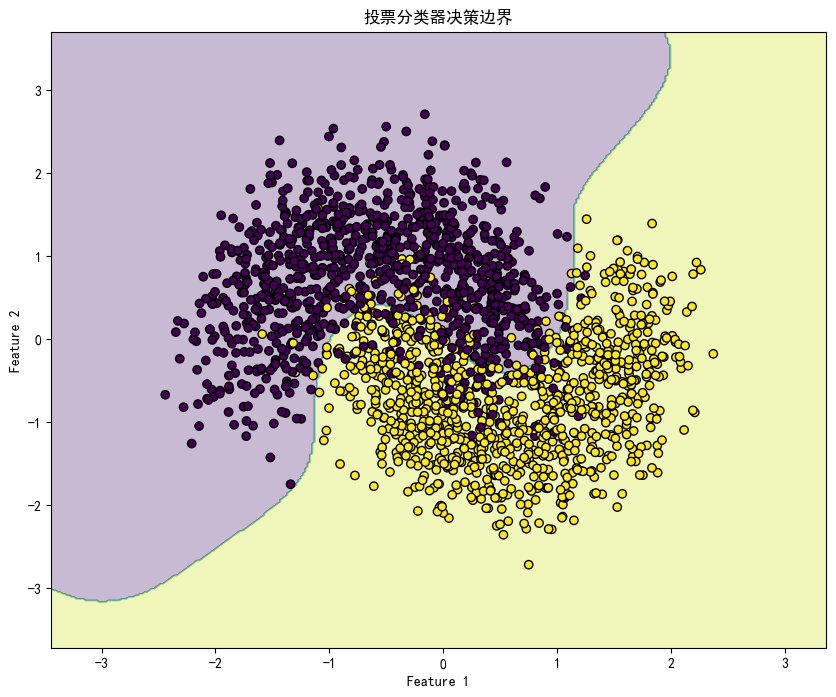

In [8]:

#可以显示中文图像，负号显示为中文
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 可视化结果
def plot_decision_boundary(clf, X, y, title):
    h = 0.02  # 网格步长
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# 可视化决策边界
plot_decision_boundary(voting_clf, X_test_scaled, y_test, '投票分类器决策边界')


In [9]:
# 手动实现投票分类器
ensemble_pred = np.array((lr_pred + svc_pred + dt_pred) >= 2, dtype='int')

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("手动集成学习准确率:", ensemble_accuracy)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"投票分类器准确率: {accuracy:.4f}")

手动集成学习准确率: 0.927
投票分类器准确率: 0.9270


# 软投票

In [10]:
# 使用软投票方式创建集成分类器
# 软投票使用预测的概率而不是类标签进行投票
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svc', svc_clf),
        ('dt', dt_clf)
    ],
    voting='soft'  # 使用软投票
)

# 由于SVC默认不返回概率，我们需要确保已经设置probability=True
# 如果没有设置，可以重新训练
if not hasattr(svc_clf, 'predict_proba'):
    print("重新训练SVC以启用概率预测")
    svc_clf = SVC(probability=True, gamma='auto')
    svc_clf.fit(X_train, y_train)
    
    # 更新集成分类器中的SVC
    soft_voting_clf.estimators[1] = ('svc', svc_clf)

# 训练软投票分类器
soft_voting_clf.fit(X_train, y_train)

# 评估软投票分类器
soft_voting_pred = soft_voting_clf.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, soft_voting_pred)
print("软投票集成分类器准确率:", soft_voting_accuracy)



软投票集成分类器准确率: 0.926


# BaggingClassifier 并向集成学习

In [11]:
# 使用决策树作为基分类器创建Bagging集成分类器
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 创建决策树基分类器
base_dt = DecisionTreeClassifier(random_state=42)

# 创建Bagging分类器
# n_estimators: 集成中基分类器的数量
# max_samples: 每个基分类器训练时使用的样本数量(可以是整数或比例)，不能超过训练集的样本数量
# bootstrap: True表示有放回抽样
bagging_clf = BaggingClassifier(
    base_dt,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,
    random_state=42
)

# 训练Bagging分类器
bagging_clf.fit(X_train, y_train)

# 评估Bagging分类器
bagging_pred = bagging_clf.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
print("Bagging集成分类器准确率:", bagging_accuracy)



Bagging集成分类器准确率: 0.9145


In [12]:
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 创建决策树基分类器
base_dt = DecisionTreeClassifier(random_state=42)

def evaluate_bagging_performance(n_jobs,bootstrap=False):
    """
    评估Bagging分类器在不同n_jobs参数下的性能
    
    参数:
    n_jobs: 并行任务数
    bootstrap: 是否使用有放回抽样，默认为False
    
    返回:
    accuracy: 准确率
    training_time: 训练时间(秒)
    """
    # 创建Bagging分类器，bootstrap_features=True表示特征有放回抽样，选择在多特征情况下使用
    bagging_clf = BaggingClassifier(
        base_dt,
        n_estimators=100,
        max_samples=0.8,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        random_state=42
    )
    
    # 记录开始时间
    start_time = time.time()
    
    # 训练Bagging分类器
    bagging_clf.fit(X_train, y_train)
    
    # 计算训练时间
    end_time = time.time()
    training_time = end_time - start_time
    
    # 评估Bagging分类器
    bagging_pred = bagging_clf.predict(X_test)
    accuracy = accuracy_score(y_test, bagging_pred)
    
    sampling_type = "有放回抽样" if bootstrap else "不放回抽样"
    print(f"{sampling_type} Bagging (n_jobs={n_jobs}) 准确率: {accuracy:.4f}, 训练时间: {training_time:.4f}秒")
    
    return accuracy, training_time

# 测试不同的n_jobs参数
accuracy, training_time = evaluate_bagging_performance(n_jobs=-1,bootstrap=False)#使用所有CPU核心
accuracy, training_time = evaluate_bagging_performance(n_jobs=1,bootstrap=False)#使用1个CPU核心
accuracy, training_time = evaluate_bagging_performance(n_jobs=2,bootstrap=False)#使用2个CPU核心
accuracy, training_time = evaluate_bagging_performance(n_jobs=2,bootstrap=True)#使用2个CPU核心，有放回抽样


不放回抽样 Bagging (n_jobs=-1) 准确率: 0.9030, 训练时间: 9.1421秒
不放回抽样 Bagging (n_jobs=1) 准确率: 0.9030, 训练时间: 2.2545秒
不放回抽样 Bagging (n_jobs=2) 准确率: 0.9030, 训练时间: 5.4262秒
有放回抽样 Bagging (n_jobs=2) 准确率: 0.9145, 训练时间: 0.8348秒


In [13]:
# 添加njobs参数并统计训练时间
import time
from joblib import parallel_backend

# 创建一个决策树作为基分类器
base_clf = DecisionTreeClassifier(random_state=42)

# 不使用并行计算（单线程）
start_time_single = time.time()
bagging_clf_single = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    bootstrap=False,
    max_samples=5000,  
    n_jobs=1,  # 单线程
    random_state=42
)
bagging_clf_single.fit(X_train, y_train)
single_time = time.time() - start_time_single

base_clf = DecisionTreeClassifier(random_state=42)

# 使用并行计算（多线程）
start_time_multi = time.time()
bagging_clf_multi = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    bootstrap=False,
    max_samples=5000,
    n_jobs=-1,  # 使用所有可用的CPU核心，数量太少，反而导致用时增加更多
    random_state=42
)
bagging_clf_multi.fit(X_train, y_train)
multi_time = time.time() - start_time_multi

# 预测并计算准确率
single_pred = bagging_clf_single.predict(X_test)
multi_pred = bagging_clf_multi.predict(X_test)

single_accuracy = accuracy_score(y_test, single_pred)
multi_accuracy = accuracy_score(y_test, multi_pred)

# 输出结果
print("单线程 Bagging 训练时间: {:.2f}秒".format(single_time))
print("多线程 Bagging 训练时间: {:.2f}秒".format(multi_time))
print("加速比: {:.2f}倍".format(single_time / multi_time))
print()
print("决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))
print("单线程 Bagging 准确率:", single_accuracy)
print("多线程 Bagging 准确率:", multi_accuracy)


单线程 Bagging 训练时间: 1.56秒
多线程 Bagging 训练时间: 7.49秒
加速比: 0.21倍

决策树(基分类器)准确率: 0.905
单线程 Bagging 准确率: 0.91
多线程 Bagging 准确率: 0.91


# bootstrap_features=True表示特征有放回抽样，选择在多特征情况下使用

# ExtraTreesClassifier

In [14]:
# 创建ExtraTrees分类器，中文名：极端随机森林
# ExtraTrees（Extremely Randomized Trees）是一种集成学习方法，它与随机森林类似，但在树的构建过程中引入了更多的随机性,随机阈值，随机特征

# 导入ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

# 创建ExtraTrees分类器
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100,  # 使用100个树
    criterion='gini',  # 使用基尼指数作为分裂标准
    max_depth=None,    # 树的最大深度，None表示不限制
    min_samples_split=2,  # 分裂一个内部节点所需的最小样本数
    min_samples_leaf=1,   # 在叶节点处需要的最小样本数
    max_features='sqrt',  # 寻找最佳分割时考虑的特征数量
    bootstrap=False,      # 是否使用bootstrap抽样，False表示不放回抽样
    random_state=42,      # 随机种子，确保结果可复现
)

# 训练ExtraTrees分类器
extra_trees_clf.fit(X_train, y_train)

# 预测
extra_trees_pred = extra_trees_clf.predict(X_test)
extra_trees_accuracy = accuracy_score(y_test, extra_trees_pred)

# 输出结果
print("决策树(基分类器)准确率:", accuracy_score(y_test, dt_pred))
print("Bagging集成准确率:", bagging_accuracy)
print("ExtraTrees集成准确率:", extra_trees_accuracy)

决策树(基分类器)准确率: 0.905
Bagging集成准确率: 0.9145
ExtraTrees集成准确率: 0.9095


# 串行

# GBDT

(100,)
GBDT集成准确率: 0.928


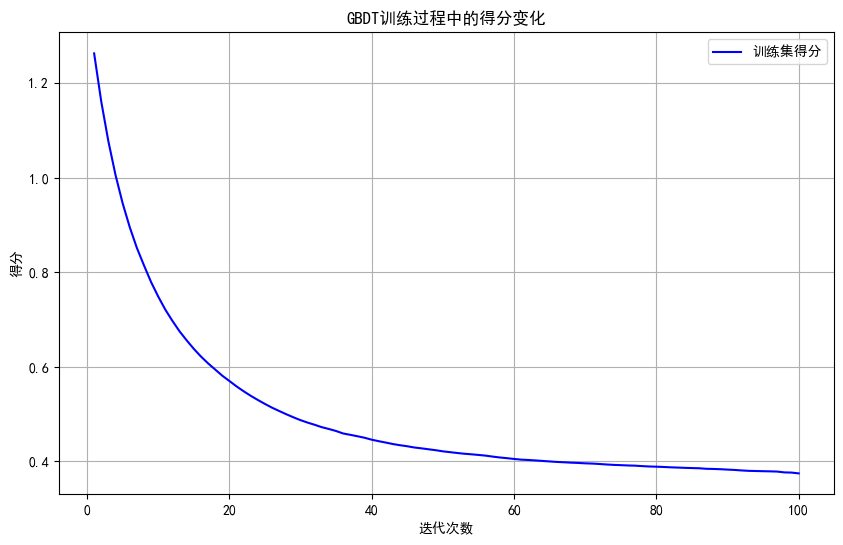

In [15]:
# 导入梯度提升决策树分类器
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

# 创建GBDT分类器
gbdt_clf = GradientBoostingClassifier(
    n_estimators=100,           # 弱分类器的数量
    learning_rate=0.1,          # 学习率
    max_depth=3,                # 决策树的最大深度
    min_samples_split=2,        # 分裂内部节点所需的最小样本数
    min_samples_leaf=1,         # 叶节点所需的最小样本数
    subsample=1.0,              # 用于拟合各个基础学习器的样本比例
    random_state=42             # 随机种子，确保结果可复现
)

# 训练GBDT分类器
gbdt_clf.fit(X_train, y_train)

# 预测
gbdt_pred = gbdt_clf.predict(X_test)
gbdt_accuracy = accuracy_score(y_test, gbdt_pred)

print(gbdt_clf.train_score_.shape) # 训练集得分
print("GBDT集成准确率:", gbdt_accuracy)


# 绘制GBDT的训练过程中的损失函数变化
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(gbdt_clf.train_score_) + 1), gbdt_clf.train_score_, 'b-', label='训练集得分')
plt.xlabel('迭代次数')
plt.ylabel('得分')
plt.title('GBDT训练过程中的得分变化')
plt.legend()
plt.grid(True)
plt.show()


# AdaBoost

In [16]:
# 导入AdaBoost分类器
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

# 创建基分类器 - 使用决策树作为AdaBoost的基分类器
base_clf = DecisionTreeClassifier(max_depth=1)  # 决策树桩(深度为1的决策树)

# 创建AdaBoost分类器
ada_clf = AdaBoostClassifier(
    estimator=base_clf,         # 基分类器
    n_estimators=50,            # 弱分类器的数量
    learning_rate=1.0,          # 学习率
    random_state=42             # 随机种子，确保结果可复现
)

# 训练AdaBoost分类器
ada_clf.fit(X_train, y_train)

# 预测
ada_pred = ada_clf.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_pred)

print("AdaBoost集成准确率:", ada_accuracy)


AdaBoost集成准确率: 0.9055


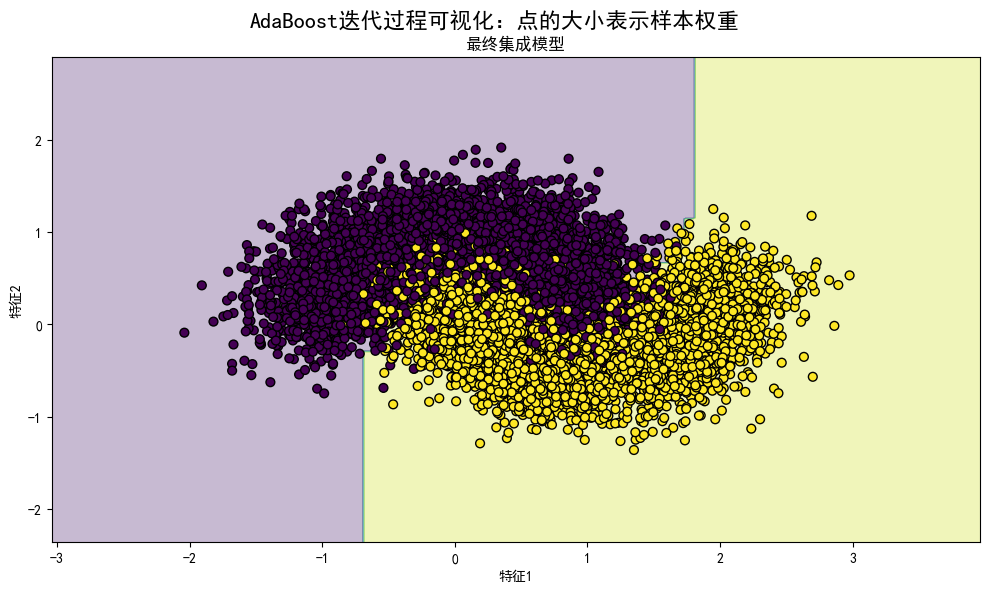

In [20]:
# 添加最终集成模型的结果
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(10, 6))
Z_final = ada_clf.predict(grid_points)
Z_final = Z_final.reshape(xx.shape)
plt.contourf(xx, yy, Z_final, alpha=0.3, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', 
            edgecolors='k', s=40)
plt.title('最终集成模型')
plt.xlabel('特征1')
plt.ylabel('特征2')

plt.tight_layout()
plt.suptitle('AdaBoost迭代过程可视化：点的大小表示样本权重', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()